# Building MVP model
### Jeff Ho

This notebook shows initial model building. The plan is to build a multinomial logistic regression model based on 1-hot-encoded presence of the top ingredients by cuisine

**Question:**
Can we design and execute a method to predict the cuisine of a recipe given only its ingredients?

**Deliverables:**
Produce guidelines for a team to hand label cuisines based on ingredients.

**Why?**
To improve the product by building a feature for the food publication that enables users to query by cuisine.

In [93]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics

import pydotplus
from IPython.display import Image

### Build dataframe for modeling


In [17]:
# load data
raw_df = pd.read_json('recipies.json')
df = raw_df.explode('ingredients')
display(df.head())
display(len(df))

,id,cuisine,ingredients
0,10259,greek,romaine lettuce
0,10259,greek,black olives
0,10259,greek,grape tomatoes
0,10259,greek,garlic
0,10259,greek,pepper


428275

In [6]:
freq_ingredients = ['salt', 'onions', 'olive oil', 'lime', 'water', 'garlic cloves', 'garlic', 'cachaca', 'sugar', 'tomatoes', 'all-purpose flour', 'butter', 'milk', 'eggs', 'unsalted butter', 'baking powder', 'large eggs', 'green bell pepper', 'cayenne pepper', 'cajun seasoning', 'soy sauce', 'sesame oil', 'corn starch', 'green onions', 'vegetable oil', 'scallions', 'pepper', 'oil', 'carrots', 'ground black pepper', 'dried oregano', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'garam masala', 'ground turmeric', 'cumin seed', 'ground cumin', 'potatoes', 'baking soda', 'grated parmesan cheese', 'ground allspice', 'dried thyme', 'black pepper', 'mirin', 'sake', 'rice vinegar', 'ginger', 'sesame seeds', 'chili powder', 'jalapeno chilies', 'sour cream', 'avocado', 'corn tortillas', 'ground cinnamon', 'ground ginger', 'paprika', 'buttermilk', 'red bell pepper', 'fish sauce', 'coconut milk', 'fresh lime juice', 'shallots']
print(freq_ingredients)

['salt', 'onions', 'olive oil', 'lime', 'water', 'garlic cloves', 'garlic', 'cachaca', 'sugar', 'tomatoes', 'all-purpose flour', 'butter', 'milk', 'eggs', 'unsalted butter', 'baking powder', 'large eggs', 'green bell pepper', 'cayenne pepper', 'cajun seasoning', 'soy sauce', 'sesame oil', 'corn starch', 'green onions', 'vegetable oil', 'scallions', 'pepper', 'oil', 'carrots', 'ground black pepper', 'dried oregano', 'feta cheese crumbles', 'extra-virgin olive oil', 'fresh lemon juice', 'garam masala', 'ground turmeric', 'cumin seed', 'ground cumin', 'potatoes', 'baking soda', 'grated parmesan cheese', 'ground allspice', 'dried thyme', 'black pepper', 'mirin', 'sake', 'rice vinegar', 'ginger', 'sesame seeds', 'chili powder', 'jalapeno chilies', 'sour cream', 'avocado', 'corn tortillas', 'ground cinnamon', 'ground ginger', 'paprika', 'buttermilk', 'red bell pepper', 'fish sauce', 'coconut milk', 'fresh lime juice', 'shallots']


In [56]:
%%time
#filter recipe list to only include top ingredients
id_top_ingredients_long = df.loc[df['ingredients'].isin(freq_ingredients)]
id_top_ingredients_long = id_top_ingredients_long[['id','ingredients']]

# add a column of ones so we can use .unstack to make a wide matrix
id_top_ingredients_long['ingredient'] = 1
id_top_ingredients_long.drop_duplicates(inplace=True)
id_top_ingredients_long.set_index(['id','ingredients'],inplace=True)
id_top_ingredients_long

# 1-hot encode the top 10 ingredients by cuisine in a wide matrix
id_top_ingredients_wide = id_top_ingredients_long.unstack(fill_value=0)
id_top_ingredients_wide

# join target column back in:
df_modeling = id_top_ingredients_wide.join(raw_df[['id','cuisine']].set_index('id'))
display(df_modeling)

# check join worked
display(df_modeling.loc[6]) #both should have "chinese" as cuisine
display(raw_df.loc[raw_df['id']==6])

,"(ingredient, all-purpose flour)","(ingredient, avocado)","(ingredient, baking powder)","(ingredient, baking soda)","(ingredient, black pepper)","(ingredient, butter)","(ingredient, buttermilk)","(ingredient, cachaca)","(ingredient, cajun seasoning)","(ingredient, carrots)",...,"(ingredient, sesame seeds)","(ingredient, shallots)","(ingredient, sour cream)","(ingredient, soy sauce)","(ingredient, sugar)","(ingredient, tomatoes)","(ingredient, unsalted butter)","(ingredient, vegetable oil)","(ingredient, water)",cuisine
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spanish
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,mexican
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,french
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,chinese
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,chinese
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49712,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,indian
49713,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,southern_us
49714,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,irish


(ingredient, all-purpose flour)          0
(ingredient, avocado)                    0
(ingredient, baking powder)              0
(ingredient, baking soda)                0
(ingredient, black pepper)               0
                                    ...   
(ingredient, tomatoes)                   0
(ingredient, unsalted butter)            0
(ingredient, vegetable oil)              0
(ingredient, water)                      0
cuisine                            chinese
Name: 6, Length: 64, dtype: object

,id,cuisine,ingredients
16474,6,chinese,"[olive oil, sesame oil, soy sauce, flowering g..."


CPU times: user 354 ms, sys: 40.9 ms, total: 395 ms
Wall time: 359 ms


In [140]:
# Validation of model using built-in methods
def print_scores(X,y,model,y_names=None,class_report=False):
    print('Mean accuracy:')
    print(model.score(X,y))
    if class_report:
        print('Classification report')
        print(metrics.classification_report(y,model.predict(X),target_names=y_names))
    

In [109]:
# Set up modeling

# Convert target string column to a factor
factor = pd.factorize(df_modeling['cuisine'])
df_modeling['cuisine_factor'] = factor[0]
definitions = factor[1]
print(df_modeling['cuisine_factor'].head())
# print(definitions)

y_col = 'cuisine_factor'
# Final features
feature_cols = df_modeling.columns[:-2]
print('Features:')
print(feature_cols.values)

X_train, X_test, y_train, y_test = train_test_split(
    df_modeling[feature_cols], df_modeling[y_col], test_size=0.20, random_state=22)

id
0    0
1    1
2    2
3    3
6    3
Name: cuisine_factor, dtype: int64
Features:
[('ingredient', 'all-purpose flour') ('ingredient', 'avocado')
 ('ingredient', 'baking powder') ('ingredient', 'baking soda')
 ('ingredient', 'black pepper') ('ingredient', 'butter')
 ('ingredient', 'buttermilk') ('ingredient', 'cachaca')
 ('ingredient', 'cajun seasoning') ('ingredient', 'carrots')
 ('ingredient', 'cayenne pepper') ('ingredient', 'chili powder')
 ('ingredient', 'coconut milk') ('ingredient', 'corn starch')
 ('ingredient', 'corn tortillas') ('ingredient', 'cumin seed')
 ('ingredient', 'dried oregano') ('ingredient', 'dried thyme')
 ('ingredient', 'eggs') ('ingredient', 'extra-virgin olive oil')
 ('ingredient', 'feta cheese crumbles') ('ingredient', 'fish sauce')
 ('ingredient', 'fresh lemon juice') ('ingredient', 'fresh lime juice')
 ('ingredient', 'garam masala') ('ingredient', 'garlic')
 ('ingredient', 'garlic cloves') ('ingredient', 'ginger')
 ('ingredient', 'grated parmesan cheese')
 

[0.12354769 0.11596383 0.10631    0.09503717 0.07317557 0.06381042
 0.05788863 0.05780797 0.05372369 0.04169615 0.03569693 0.02943141
 0.02071154 0.02058852 0.02031211]
['grated parmesan cheese' 'soy sauce' 'garam masala' 'corn tortillas'
 'avocado' 'chili powder' 'extra-virgin olive oil' 'fish sauce'
 'olive oil' 'buttermilk' 'sesame oil' 'jalapeno chilies' 'corn starch'
 'ground cumin' 'sour cream']


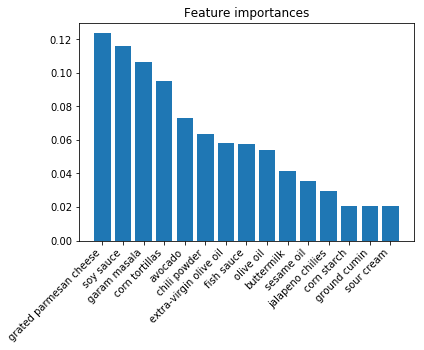

test data:
Mean accuracy:
0.41547540983606557
Classification report
              precision    recall  f1-score   support

     spanish       0.00      0.00      0.00       208
     mexican       0.57      0.59      0.58      1193
      french       0.29      0.13      0.18       516
     chinese       0.43      0.66      0.52       491
 southern_us       0.35      0.43      0.39       825
     italian       0.37      0.84      0.51      1464
      indian       0.50      0.48      0.49       620
        thai       0.49      0.37      0.42       299
cajun_creole       0.00      0.00      0.00       312
    jamaican       0.00      0.00      0.00       104
    japanese       0.34      0.29      0.31       250
       greek       0.00      0.00      0.00       224
     russian       0.00      0.00      0.00       104
       irish       0.00      0.00      0.00       123
    moroccan       0.00      0.00      0.00       158
      korean       0.00      0.00      0.00       164
    filipino 

/Users/Jeff/opt/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
# Use a classification tree for interpretability and non-linearity (e.g., soy sauce + etc)
ct = tree.DecisionTreeClassifier(min_samples_leaf=400,random_state=0)
ct.fit(X_train,y_train)

# What are the feature importances in the model?
importances = ct.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [ingred_name[1] for ingred_name in feature_cols.values]

# Plot the feature importances
top_n = 15 #how many features to get out
print(importances[indices][0:top_n])
print(np.array(feature_names)[indices][0:top_n])
plt.figure()
plt.title("Feature importances")
plt.bar(np.array(feature_names)[indices][0:top_n], importances[indices][0:top_n], align="center")
plt.xticks(rotation=45,ha='right')
# plt.xticks(np.array(feature_names)[indices][0:top_n], indices)
plt.show()

#Show test and training acuracy
print('test data:')
print_scores(X_test,y_test,ct,y_names=definitions,class_report=True)

print('training data:')
print_scores(X_train,y_train,ct)

#Show tree
print('Tree:')
dot_data = tree.export_graphviz(ct, out_file=None, 
                         feature_names=feature_cols,  
                         class_names=list(definitions.values),  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 

display(Image(graph.create_png()))